In [2]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import os
import random
import pandas as pd
import torch
from torch.utils.data import DataLoader
from transformers import TrainingArguments, AutoTokenizer, HfArgumentParser
from utils.my_trainer import CustomTrainer
from utils.utils import my_compute_metrics,seed_everything
from typing import Optional
from dataclasses import dataclass, field
from utils.data_collator import MyDataCollatorForPPathVLM, MyDataCollatorForWPathVLM, MyDataCollatorForWPathVLMTest
from peft import LoraConfig
from datasets import load_dataset, concatenate_datasets, Dataset
from model.my_model import PPathVLM, WPathVLM

In [3]:
device = 'cuda'

questions = pd.read_csv('./utils/question_wsi_list.csv', header=None)  
questions = questions[0].tolist()

def formatting_func(examples):
    question = examples["question"]
    answer = examples["answer"]
    if answer in ["yes","no"]:
        question += "Answer yes or no only!"
    text = f"<|Question|> {question}{tokenizer.eos_token}"
    examples["text"] = text
    return examples

def formatting_func_wsi(examples):
    question = random.choice(questions)
    answer = examples["label"]
    text = f"<|Question|> {question}{tokenizer.eos_token}"
    examples["text"] = text
    return examples

def tokenize(element):
    outputs = tokenizer(
        element,
        add_special_tokens=True,
        truncation=True,
        padding=False,
        max_length=512,
        return_overflowing_tokens=False,
        return_length=False)
    return {"input_ids": outputs["input_ids"], "attention_mask": outputs["attention_mask"]}

seed_everything(42)

In [4]:
# set up tokenizer
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3-8B-Instruct")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"
tokenizer.truncation_side = 'left'

new_tokens = ['<|Question|>',  '<|Answer|>', '<Image>']  # 你要添加的特殊字符列表
num_added_toks = tokenizer.add_tokens(new_tokens)
new_tokens_ids = tokenizer.convert_tokens_to_ids(new_tokens)
print("new_tokens_ids: ", new_tokens_ids)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


new_tokens_ids:  [128256, 128257, 128258]


In [5]:
# set up dataset for wsi
data_cache_dir = "/bask/projects/p/phwq4930-gbm/Zeyu/PathVLM/.cache"
dataset_local_dir = "CNX-PathLLM/TCGA-WSI-Text"
split_text = "train" # [:10000]
dataset = []

for dataset_name in dataset_local_dir.split(","):
    one_dataset = load_dataset(dataset_name, split=split_text, cache_dir=data_cache_dir)
    one_dataset = one_dataset.map(formatting_func_wsi, num_proc=20, remove_columns=['label'])
    dataset.append(one_dataset)

dataset = concatenate_datasets(dataset)
dataset = dataset.train_test_split(test_size=0.05)
eval_dataset = dataset['test']
train_dataset = dataset['train']
print(eval_dataset)

Generating train split:   2%|▏         | 196/12560 [00:09<09:29, 21.70 examples/s]


KeyboardInterrupt: 

In [ ]:
one_dataset = load_dataset(dataset_name, cache_dir=data_cache_dir)

Generating train split:  23%|██▎       | 2912/12560 [01:45<05:32, 29.01 examples/s]

In [5]:
# set up dataset
import ast

dataset_name_list = "CNX-PathLLM/PVQAClean" # CNX-PathLLM/PVQAClean CNX-PathLLM/TextbookQAPair CNX-PathLLM/PVQAClean
dataset = []
for dataset_name in dataset_name_list.split(","):
    dataset.append(load_dataset(dataset_name, split="train", cache_dir="/bask/projects/p/phwq4930-gbm/Zeyu/PathVLM/.cache"))
dataset = concatenate_datasets(dataset)
# dataset = dataset.filter(lambda x: x is not None, num_proc=20)
# for key in dataset.features.keys():
#     dataset = dataset.filter(lambda x: x[key] is not None, num_proc=20)
dataset = dataset.map(formatting_func, num_proc=20, remove_columns=["question"])
dataset = dataset.train_test_split(test_size=0.1)
dataset = dataset['test']

Repo card metadata block was not found. Setting CardData to empty.

KeyboardInterrupt



In [6]:
device = 'cuda'
# model = MyCustomModel(False, 
#                       "conch",
#                       False, 
#                       False, 
#                       "meta-llama/Meta-Llama-3-8B-Instruct", 
#                       False, 
#                       True, 
#                       tokenizer,
#                       new_tokens_ids[-1])

model = WPathVLM(False, 
                False, 
                False, 
                "meta-llama/Meta-Llama-3-8B-Instruct", 
                False, 
                True, 
                tokenizer,
                new_tokens_ids[-1],
                n_heads = 2, 
                n_level = 3, 
                embed_dim = 512,
                data_cache_dir = "/bask/projects/p/phwq4930-gbm/Zeyu/PathVLM/.cache",
                )

llm loading ...


Loading checkpoint shards: 100%|██████████| 4/4 [00:36<00:00,  9.09s/it]


In [7]:
from torch.utils.data import DataLoader

batch_size = 4  # 你可以根据需要调整批处理大小

data_collator = MyDataCollatorForWPathVLMTest(tokenizer=tokenizer, fea_dim=512, n_level=3)

In [8]:
tokenized_dataset = eval_dataset.map(
            tokenize,
            batched=False,
            # remove_columns=['text'],
            num_proc=4,
            batch_size=batch_size,
            input_columns=['text'],
       )

dataloader_params = {
            "batch_size": batch_size,
            "collate_fn": data_collator,
        }

eval_dataloader = DataLoader(tokenized_dataset, **dataloader_params)

Map (num_proc=4): 100%|██████████| 628/628 [00:17<00:00, 35.30 examples/s] 


In [9]:
# params = torch.load("/bask/homes/a/asiw9691/PathVLM/source/PathLLM/PathClip_Mistral-7B_4dataset/checkpoint-750/global_step750/mp_rank_00_model_states.pt")
ckpt = "/bask/projects/p/phwq4930-gbm/Zeyu/PathVLM/source/PathLLM/output/WSI_ConchLlama3_DES/ckpt-550.bin"
model.load_state_dict(torch.load(ckpt, map_location=device))
model.to(device)

WPathVLM(
  (llm): LlamaForCausalLM(
    (model): LlamaModel(
      (embed_tokens): Embedding(128259, 4096)
      (layers): ModuleList(
        (0-31): 32 x LlamaDecoderLayer(
          (self_attn): LlamaSdpaAttention(
            (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
            (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
            (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
            (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
            (rotary_emb): LlamaRotaryEmbedding()
          )
          (mlp): LlamaMLP(
            (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
            (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
            (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
            (act_fn): SiLU()
          )
          (input_layernorm): LlamaRMSNorm()
          (post_attention_layernorm): LlamaRMSNorm()

In [25]:
# 对于每个批次的数据
import numpy as np
from utils.eval_utils import calculate_f1score 
from tqdm import tqdm

close_ques_acc = 0
close_ques_num = 0
open_ques_f1 = []

open_candidate = []
open_reference = []

close_candidate = []
close_reference = []

# for batch in tqdm(eval_dataloader):
eval_data_iter = iter(eval_dataloader)
batch = next(eval_data_iter)
input_ids = batch['input_ids'].to(device)
attention_masks = batch['attention_mask'].to(device)
labels = batch['labels'].to(device)
fea1 = batch['fea1'].to(device)
fea2 = batch['fea2'].to(device)
fea3 = batch['fea3'].to(device)
mask1 = batch['mask1'].to(device)
mask2 = batch['mask2'].to(device)
mask3 = batch['mask3'].to(device)
answers = batch['answers']
#     break
#     # 执行模型推断
#     res = model.generate(input_ids=input_ids,
#                          attention_mask=attention_masks,
#                          fea1 = fea1,
#                          fea2 = fea2,
#                          fea3 = fea3,
#                          mask1 = mask1,
#                          mask2 = mask2,
#                          mask3 = mask3,
#                         )
    
#     break
    
#     for i in range(len(answers)):
#         if answers[i] in ['yes','no']:
#             close_candidate.append(res[i])
#             close_reference.append(answers[i])
#         else:
#             open_candidate.append(res[i])
#             open_reference.append(answers[i])

In [26]:
res = model.generate(input_ids=input_ids,
                     attention_mask=attention_masks,
                     fea1 = fea1,
                     fea2 = fea2,
                     fea3 = fea3,
                     mask1 = mask1,
                     mask2 = mask2,
                     mask3 = mask3,
                    )

In [29]:
answers[1]

'<|Question|> What can you discern from examining this histological slide?<|eot_id|> <|Answer|> The primary diagnosis is an anaplastic astrocytoma, originating from the cerebrum. The tumor is classified as WHO grade III. Histomorphological examination of the H&E stained WSI from the tumor center reveals increased cellularity, pleomorphism, detectable mitotic activity, and focal proliferation up to 10%. For further characterization, related immunohistochemistry (IHC) tests such as IDH1, p53, and ATRX are recommended.<|eot_id|>\n'

In [30]:
res[1]

' <|Answer|> The primary diagnosis is an Anaplastic Astrocytoma (WHO grade III) located in the left parietal lobe of the cerebrum. Histologically, the tumor cells exhibit increased cellularity with pleomorphic features, mitotic activity, and focal proliferation up to 10%. GFAP immunostaining confirms the astrocytic origin. It is recommended to consider additional IHC tests such as IDH1, p53, ATRX, and MGMT promoter methylation status for further characterization and prognostic assessment. Microsatellite instability testing has been ordered, and it is recommended to perform related IHC tests including MLH1, MSH2, MSH6, PMS2, and MSH7). Genetic testing identified no deletions of chromosome arms 1p and 19q. Relevant mutational analysis results include a codon 132 c.394C>T p.Arg132Tru mutation in IDH1 and a codon 72 c.G>A p.Arg72Gly mutation in EGFR amplification, with positive staining for the mutant protein. Further clinical correlation is advised. Related IHC tests to consider include E

In [11]:
from rouge import Rouge 
rouge = Rouge()
open_ques_rouge = []

for i in range(len(close_reference)):
    close_ques_num += 1
    if close_reference[i] in close_candidate[i]:
        close_ques_acc += 1
        
for i in range(len(open_reference)):
    f1_score = calculate_f1score(open_candidate[i], open_reference[i])
    open_ques_f1.append(f1_score)
    
open_ques_rouge = rouge.get_scores(open_candidate, open_reference, avg=True) 
open_ques_f1 = np.mean(open_ques_f1)
close_ques_acc = close_ques_acc/close_ques_num

print(open_ques_rouge)
print(open_ques_f1)
print(close_ques_acc)

{'rouge-1': {'r': 0.27001985016993246, 'p': 0.017507060508135417, 'f': 0.03129752911526289}, 'rouge-2': {'r': 0.05284908234126984, 'p': 0.0023333627239040663, 'f': 0.004323536432612713}, 'rouge-l': {'r': 0.2615928062936698, 'p': 0.016450324600026073, 'f': 0.02950558446856401}}
0.04000689721539458
0.9538043478260869


In [20]:
scores = compute_bleu_scores(open_candidate, open_reference, avg=True)

In [21]:
scores

0.23677331586807712

### For one image QA test

In [37]:
from PIL import Image

question = "What is your final diagnosis?"
text = f"<|Question|> {question}{tokenizer.eos_token}"
image = Image.open("./test_images/test1.jpeg")

# i = 1
# text = dataset[i]['text']
# image = dataset[i]['image']
# answer = dataset[i]['answer']

input_dic = tokenizer(text, return_tensors="pt")
map_image_data = model.image_processor(image)
input_dic["image"] = map_image_data

res = model.generate(input_ids = input_dic["input_ids"].to(device),
                    attention_mask = input_dic["attention_mask"].to(device),
                    labels = input_dic["input_ids"].to(device),
                    image = input_dic["image"].unsqueeze(0).to(device),
                    temperature = 0.7,
                    top_p = 0.9,
                    num_return_sequences = 3,
                )

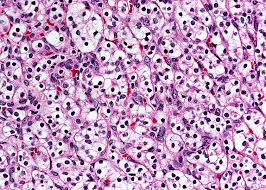

In [38]:
image

In [39]:
text

'<|Question|> What is your final diagnosis?<|end_of_text|>'

In [40]:
res

['<|Answer|> The final diagnosis is renal cell carcinoma, clear cell type. Grade 4 with large nucleoli and high grade nucleoli is visible in some areas of the tumor. A few foci contain prominent nucleoli, raising the possibility of grade 5 (poorly cohesive) RCC. Tumor growth appears somewhat nested/organoid but tends to fill the space more than true nests. Delicate arborizing thin walled venules']

In [24]:
answer

'yes'

In [13]:
!nvidia-smi

Mon May 13 11:51:22 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  | 00000000:CA:00.0 Off |                    0 |
| N/A   28C    P0              55W / 400W |  40338MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--